In [1]:
import pandas as pd

data = pd.read_csv('C:/Users/user/Desktop/22.1~택시배차최적화/data.csv')
data = data.sample(n=20, random_state = 67)
#sample = data.sample(frac=0.8,random_state = 67)
import pickle
## Load pickle
with open("C:/Users/user/Desktop/22.1~택시배차최적화/random_passenger.pickle","rb") as fr:
    random_passenger = pickle.load(fr)
    
random_ = random_passenger.sample(n=3,random_state = 67)    

In [2]:
###packages 
import networkx as nx 
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
ox.__version__

'1.1.2'

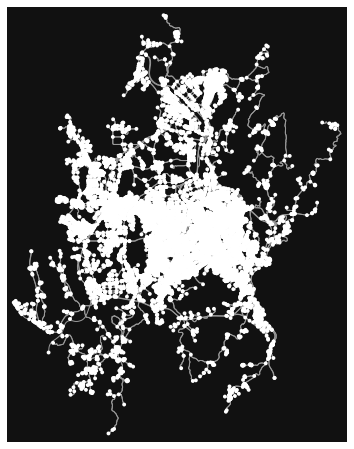

In [3]:
#download / model a street network for some city then visualize it 
G = ox.graph_from_place("대전, 대한민국", network_type="drive")
fig, ax = ox.plot_graph(G)

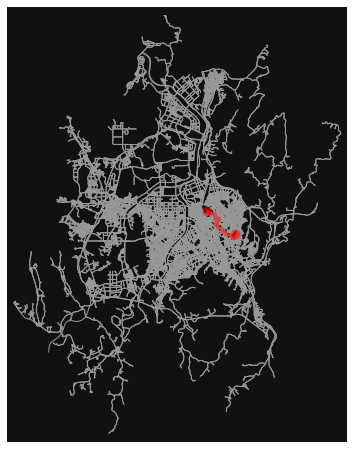

In [57]:
orig = ox.distance.nearest_nodes(G, X=127.4458, Y=36.3372)
dest = ox.distance.nearest_nodes(G, X=127.42070 , Y=36.35527)
#find the shortest path between nodes. minimizing travel time. then plot it 
route = ox.shortest_path(G, orig, dest, weight="travel_time")

fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [4]:
random_ = random_.reset_index()

In [55]:
from tqdm import tqdm
matrix_list = []
for data_index in tqdm(data.index):
    x_list = []
    y_list = []
    dprt_comb = list(permutations(random_.index, 3))[0]
    for i in range(3):
        globals()[f'dprt_x{i}'] = random_['dprt_lon'][i]
        x_list.append(globals()[f'dprt_x{i}'])
        globals()[f'dprt_y{i}'] = random_['dprt_lat'][i]
        y_list.append(globals()[f'dprt_y{i}'])
    arri_comb = list(permutations(random_.index, 3))
    for i in range(3):
        globals()[f'arr_x{i}'] = random_['arrive_lon'][i]
        x_list.append(globals()[f'arr_x{i}'])
        globals()[f'arr_y{i}'] = random_['arrive_lat'][i]    
        y_list.append(globals()[f'arr_y{i}'])
    x_list.insert(0,data['dprt_x'][data_index])    
    y_list.insert(0,data['dprt_y'][data_index])    
    arri_comb = list(permutations(random_.index+3, 3))
    dist_list = []
    for arri_i in arri_comb:
        comb_list = list(dprt_comb+arri_i)
        route_list = []
        for dist_num in range(len(comb_list)-1):
            orig = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num]],
                                            Y=y_list[comb_list[dist_num]])
            dest = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num+1]] , Y=y_list[comb_list[dist_num+1]])
            route = ox.shortest_path(G, orig, dest, weight="length")
            route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
            route_list.append(route_length)    
        orig = ox.distance.nearest_nodes(G, X=x_list[-2],
                                            Y=y_list[-2])
        dest = ox.distance.nearest_nodes(G, X=x_list[-1] , Y=y_list[-1])
        route = ox.shortest_path(G, orig, dest, weight="length")
        route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
        route_list.append(route_length)    
        dist_list.append(sum(route_list))
    matrix_list.append(dist_list)   

  0%|          | 0/20 [00:00<?, ?it/s]


KeyError: 'travel_time'

In [26]:
matrix_list

[[60419, 56088, 60534, 65676, 44988, 54691],
 [64198, 59867, 64313, 69455, 48767, 58470],
 [64502, 60171, 64617, 69759, 49071, 58774],
 [65333, 61002, 65448, 70590, 49902, 59605],
 [62993, 58662, 63108, 68250, 47562, 57265],
 [65719, 61388, 65834, 70976, 50288, 59991],
 [66094, 61763, 66209, 71351, 50663, 60366],
 [64086, 59755, 64201, 69343, 48655, 58358],
 [65656, 61325, 65771, 70913, 50225, 59928],
 [64120, 59789, 64235, 69377, 48689, 58392],
 [61773, 57442, 61888, 67030, 46342, 56045],
 [62432, 58101, 62547, 67689, 47001, 56704],
 [68128, 63797, 68243, 73385, 52697, 62400],
 [64746, 60415, 64861, 70003, 49315, 59018],
 [63068, 58737, 63183, 68325, 47637, 57340],
 [60847, 56516, 60962, 66104, 45416, 55119],
 [74244, 69913, 74359, 79501, 58813, 68516],
 [61297, 56966, 61412, 66554, 45866, 55569],
 [61681, 57350, 61796, 66938, 46250, 55953],
 [60308, 55977, 60423, 65565, 44877, 54580]]

In [27]:
from ortools.linear_solver import pywraplp
num_taxis = len(matrix_list)
num_passenger = len(matrix_list[0])

#Declare the MIP solver
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

#Create the variables
# x[i, j] is an array of 0-1 variables, which will be 1
# if worker i is assigned to task j.
x = {}
for i in range(num_taxis):
    for j in range(num_passenger):
        x[i, j] = solver.IntVar(0, 1, '')

#Create the constraints
# Each worker is assigned to at most 1 task.
for i in range(num_taxis):
    solver.Add(solver.Sum([x[i, j] for j in range(num_passenger)]) <= 1)

# Each task is assigned to exactly one worker.
for j in range(num_passenger):
    solver.Add(solver.Sum([x[i, j] for i in range(num_taxis)]) == 1)

#Create the objective function
objective_terms = []
for i in range(num_taxis):
    for j in range(num_passenger):
        objective_terms.append(matrix_list[i][j] * x[i, j])
solver.Minimize(solver.Sum(objective_terms))
#목적함수의 값은 solver에 의해 값 1이 할당된 모든 변수의 총 비용

#Invoke the solver
status = solver.Solve()

i_list = []
j_list = []
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    #print('Total distance = ', solver.Objective().Value(), '\n')
    for i in range(num_taxis):
        for j in range(num_passenger):
            # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
            if x[i, j].solution_value() > 0.5:
                print('taxi %d assigned to route %d.  distance = %d' %
                    (i, j, matrix_list[i][j]))  
                i_list.append(i) 
                j_list.append(j)



taxi 0 assigned to route 4.  distance = 44988
taxi 10 assigned to route 0.  distance = 61773
taxi 15 assigned to route 3.  distance = 66104
taxi 17 assigned to route 2.  distance = 61412
taxi 18 assigned to route 1.  distance = 57350
taxi 19 assigned to route 5.  distance = 54580


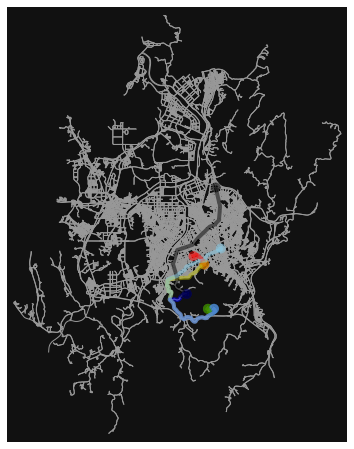

In [13]:
fig, ax = ox.plot_graph_routes(
    G, routes=[route0, route1,route2,route3,route4,route5], route_colors=["r", "y",'g','b','k','skyblue'], route_linewidth=6, node_size=0
)

In [ ]:
for arri_i in arri_comb[4:5]:
    comb_list = list(dprt_comb+arri_i)
    route_list = []
    for dist_num in range(len(comb_list)-1):
        orig = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num]],
                                        Y=y_list[comb_list[dist_num]])
        dest = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num+1]] , Y=y_list[comb_list[dist_num+1]])
        globals()[f'route{dist_num}'] = ox.shortest_path(G, orig, dest, weight="length")
        print(dist_num)
orig5 = ox.distance.nearest_nodes(G, X=x_list[-2],
                                    Y=y_list[-2])
dest5 = ox.distance.nearest_nodes(G, X=x_list[-1] , Y=y_list[-1])
route5 = ox.shortest_path(G, orig5, dest5, weight="length")      

0
1
2
3
4


In [ ]:
from tqdm import tqdm
from itertools import permutations 
matrix_list = []
for data_index in tqdm(data.index[:1]):
    x_list = []
    y_list = []
    dprt_comb = list(permutations(random_.index, 3))[0]
    for i in range(3):
        globals()[f'dprt_x{i}'] = random_['dprt_lon'][i]
        x_list.append(globals()[f'dprt_x{i}'])
        globals()[f'dprt_y{i}'] = random_['dprt_lat'][i]
        y_list.append(globals()[f'dprt_y{i}'])
    arri_comb = list(permutations(random_.index, 3))
    for i in range(3):
        globals()[f'arr_x{i}'] = random_['arrive_lon'][i]
        x_list.append(globals()[f'arr_x{i}'])
        globals()[f'arr_y{i}'] = random_['arrive_lat'][i]    
        y_list.append(globals()[f'arr_y{i}'])
    x_list.insert(0,data['dprt_x'][data_index])    
    y_list.insert(0,data['dprt_y'][data_index])    
    arri_comb = list(permutations(random_.index+3, 3))
    dist_list = []

            

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


In [42]:
for arri_i in arri_comb[4:5]:
    comb_list = list(dprt_comb+arri_i)
    route_list = []
    for dist_num in range(len(comb_list)-1):
        orig = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num]],
                                        Y=y_list[comb_list[dist_num]])
        dest = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num+1]] , Y=y_list[comb_list[dist_num+1]])
        globals()[f'route{dist_num}'] = ox.shortest_path(G, orig, dest, weight="length")
        print(dist_num)
orig5 = ox.distance.nearest_nodes(G, X=x_list[dist_num],
                                    Y=y_list[dist_num])
dest5 = ox.distance.nearest_nodes(G, X=x_list[-1] , Y=y_list[-1])
route5 = ox.shortest_path(G, orig5, dest5, weight="length")      

0
1
2
3
4


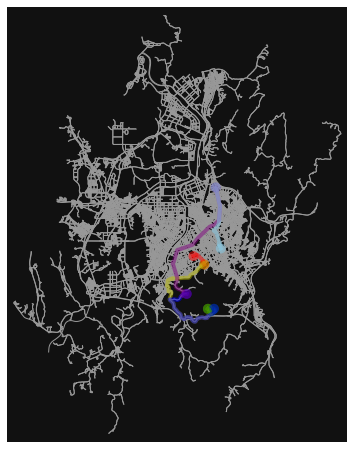

In [60]:
fig, ax = ox.plot_graph_routes(
    G, routes=[route0, route1,route2,route3,route4,route5], route_colors=["r", "y",'g','b','purple','skyblue'], route_linewidth=6, node_size=0
)

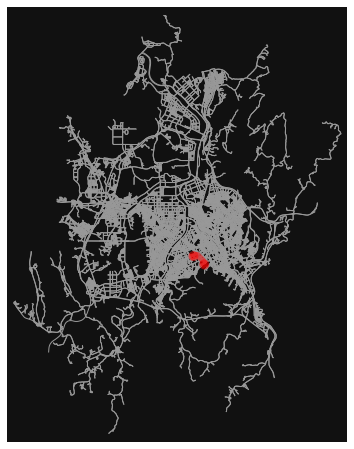

In [61]:
fig, ax = ox.plot_graph_route(
    G, route0, route_color="r", route_linewidth=6, node_size=0
)

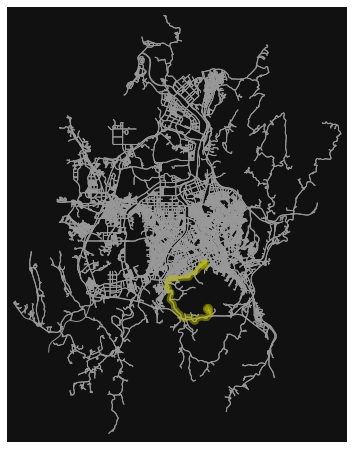

In [62]:
fig, ax = ox.plot_graph_route(
    G, route1, route_color="y", route_linewidth=6, node_size=0
)

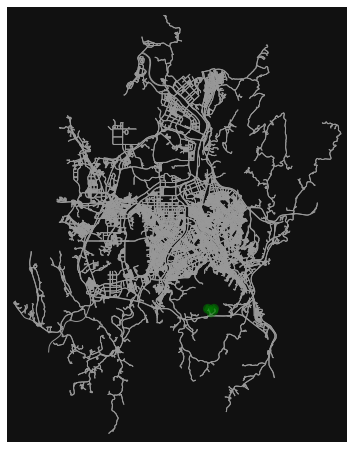

In [63]:
fig, ax = ox.plot_graph_route(
    G, route2, route_color="g", route_linewidth=6, node_size=0
)

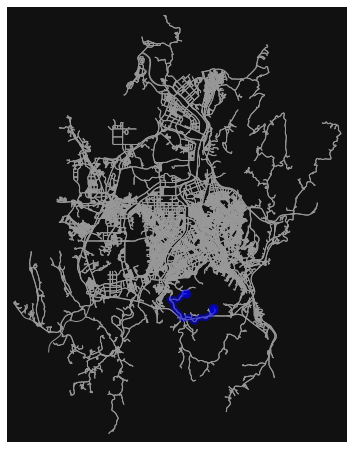

In [64]:
fig, ax = ox.plot_graph_route(
    G, route3, route_color="b", route_linewidth=6, node_size=0
)

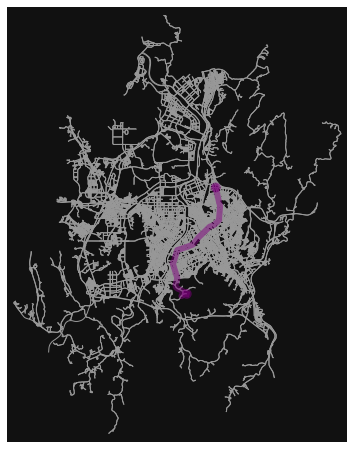

In [65]:
fig, ax = ox.plot_graph_route(
    G, route4, route_color="purple", route_linewidth=6, node_size=0
)

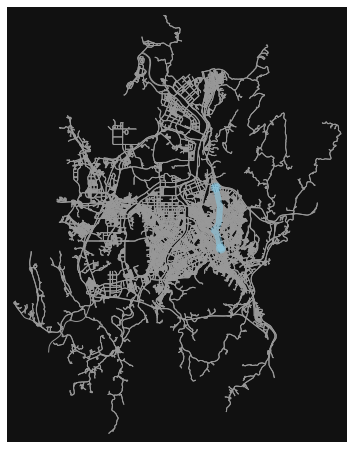

In [66]:
fig, ax = ox.plot_graph_route(
    G, route5, route_color="skyblue", route_linewidth=6, node_size=0
)